In [1]:
#import relevant libraries 
import pandas as pd
import plotly.express as px
import panel as pn
import hvplot.pandas
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
import os
from datetime import datetime, timedelta,date
from pandas import DataFrame



In [2]:
## Get Market Data for S&P500 
#engage API keys by activating .env file for Alpaca Api
load_dotenv()
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

#function to read the api data for stock ticker
#returns dataframe of closing price and daily returns for a given ticker symbol
def get_ticker_data(api,ticker):
    #load in historical data for provided ticker
    stock_data_df = api.alpha_vantage.historic_quotes(ticker, adjusted=True, output_format='pandas')

    #Clean Data
    

    #Sort earliest to latest. so that .pct_change() function works right.
    stock_data_df.sort_index(inplace=True, ascending=True)

    # Drop nulls
    stock_data_df.dropna(inplace=True)

    # drop duplicates
    stock_data_df.drop_duplicates(inplace=True)

    #count nulls 
    stock_data_df.isnull().sum()

    #create a dataframe column for the daily returns (pct_change) values and concat 
    returns_df = stock_data_df['5. adjusted close'].pct_change()
    stock_data_df = pd.concat([stock_data_df, returns_df], axis="columns", join="inner")

    #Change column names to avoid confusion
    columns = ['Open','High','Low','Close','Adjusted Close','Volume','Dividend Amount','Split Coefficient','Daily Returns']
    stock_data_df.columns = columns

    # Drop nulls
    stock_data_df.dropna(inplace=True)

    #drop duplicates
    stock_data_df.drop_duplicates(inplace=True) 
    return stock_data_df

In [3]:
stock_data_df=get_ticker_data(api,'SPY')

In [4]:
# function to get the MACD Value of the returns
# return MACD signal values dataframe
def get_MACD(stock_data_df,ticker, span1, span2,span3): ##typically span = 12, 26, 9
    # Grab just the `date` and `close` from the dataset
    macd_signals = stock_data_df.loc[:, ['Close']].copy()

    
    exp1 = macd_signals.Close.ewm(span1, adjust=False).mean()
    exp2 = macd_signals.Close.ewm(span2, adjust=False).mean()
    macd = exp1-exp2
    macd_out = macd.ewm(span3, adjust=False).mean()
    
    macd_signals["Signal"] = np.where(macd > macd_out, 1.0, 0.0)
    macd_signals["MACD Entry/Exit"] = mac_signals["Signal"].diff()

    return macd_signals


In [24]:
class MACDSimulator():
    def __init__(self, stock_data_df, period, span1, span2, span3, figsize = None):
        self.stock_data_df = stock_data_df
        self.period = period
        self.span1 = span1
        self.span2 = span2
        self.span3 = span3
        self.figsize = figsize

    def _build_dataframe(self):
        self.stock_data_df.sort_index(ascending=True, inplace=True)
    
    def _macd(self):
        self.stock_data_df['exp1'] = self.stock_data_df.Close.ewm(self.span1, adjust=False).mean()
        self.stock_data_df['exp2'] = self.stock_data_df.Close.ewm(self.span2, adjust=False).mean()
        self.stock_data_df['macd'] = self.stock_data_df.exp1-self.stock_data_df.exp2
        self.stock_data_df['macdout'] = self.stock_data_df.macd.ewm(self.span3, adjust=False).mean()

    def _calculate_macd_signals(self):
        self.stock_data_df['MACD Signal'] = None

        self.stock_data_df["MACD Signal"] = np.where(self.stock_data_df['macd'] > self.stock_data_df['macdout'], 1.0, 0.0)
        self.stock_data_df["MACD Entry/Exit"] = self.stock_data_df["MACD Signal"].diff()

    def _returns(self):
        self.stock_data_df['MACD Signal'].fillna(method='ffill', inplace=True)
        self.stock_data_df['MACD Daily Return'] = self.stock_data_df['Close'].pct_change()
        self.stock_data_df['MACD Strategy Return'] = self.stock_data_df['MACD Daily Return'] * self.stock_data_df['MACD Signal']

    def _plot_returns(self):
        self.stock_data_df['MACD Strategy Return'].cumsum().plot(figsize=self.figsize)

    def simulate(self):
        self._build_dataframe()
        self._macd()
        self._calculate_macd_signals()
        self._returns()
        self._plot_returns()

        return (
            self.period, 
            self.span1, 
            self.span2, 
            self.span3,
            self.stock_data_df['MACD Strategy Return'].sum(),
            self.stock_data_df['MACD Signal']
        )

In [25]:
#MACD Optimal Calculation
def MACD_Optimal(stock_data_df):
    span1s = np.linspace(10, 100, 5, dtype=int)
    span2s= np.linspace(10, 100, 5, dtype=int)
    span3s= np.linspace(10, 100, 5, dtype=int)
    periods = np.array([12, 48])

    result_df = pd.DataFrame({
        'period': [], 
        'span1': [],
        'span2': [],
        'span3': [],
        'result': []
    })

    for span1 in span1s:
        for span2 in span2s:
            for span3 in span3s:
                for period in periods:
                    simulator = MACDSimulator(
                        stock_data_df, 
                        #from_date 
                        period="{}H".format(period), 
                        span1=span1, 
                        span2=span2, 
                        span3=span3,
                        figsize=(14, 7)
                    )
                    period, span1, span2, span3, result, signal = simulator.simulate()
                    result_df = result_df.append({
                        'period': period, 
                        'span1': span1, 
                        'span2': span2, 
                        'span3': span3,
                        'result': result,
                        'signal': signal
                    }, ignore_index=True)
    macd_result=result_df.sort_values(by=['result'], ascending=False)[:5]
    return macd_result

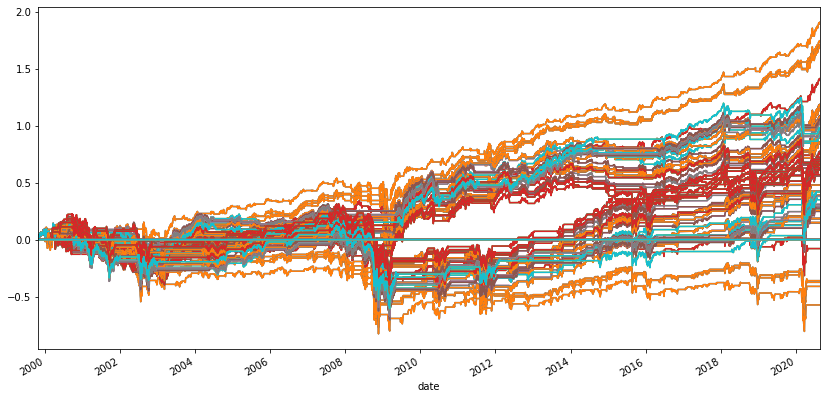

In [26]:
macd_opt=MACD_Optimal(stock_data_df)

In [27]:
macd_opt.head()

,period,span1,span2,span3,result,signal
10,12H,10.0,32.0,10.0,1.907123,date 1999-11-02 0.0 1999-11-03 1.0 1999-...
11,48H,10.0,32.0,10.0,1.907123,date 1999-11-02 0.0 1999-11-03 1.0 1999-...
21,48H,10.0,55.0,10.0,1.744110,date 1999-11-02 0.0 1999-11-03 1.0 1999-...
20,12H,10.0,55.0,10.0,1.744110,date 1999-11-02 0.0 1999-11-03 1.0 1999-...
31,48H,10.0,77.0,10.0,1.708497,date 1999-11-02 0.0 1999-11-03 1.0 1999-...


In [28]:
period=macd_opt['period'].iloc[0]
span1=macd_opt['span1'].iloc[0]
span2=macd_opt['span2'].iloc[0]
span3=macd_opt['span3'].iloc[0]

('12H', 10.0, 32.0, 10.0, 1.9071234798725847, date
 1999-11-02    0.0
 1999-11-03    1.0
 1999-11-04    1.0
 1999-11-05    1.0
 1999-11-08    1.0
              ... 
 2020-08-12    1.0
 2020-08-13    1.0
 2020-08-14    1.0
 2020-08-17    1.0
 2020-08-18    1.0
 Name: MACD Signal, Length: 5232, dtype: float64)

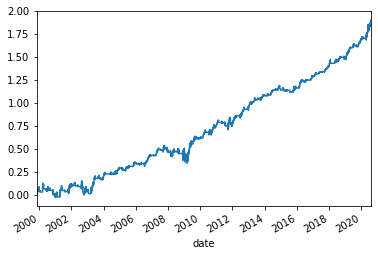

In [29]:
simulator = MACDSimulator(
    stock_data_df, 
    #from_date="2018-01-01", 
    period=period, 
    span1=span1,
    span2=span2,
    span3=span3
)
simulator.simulate()

In [33]:
stock_data_df.dropna(subset=['MACD Signal']).tail(30)

,Open,High,Low,Close,Adjusted Close,Volume,Dividend Amount,Split Coefficient,Daily Returns,exp1,exp2,macd,MACD Signal,macdout,MACD Entry/Exit,MACD Daily Return,MACD Strategy Return
date,,,,,,,,,,,,,,,,,
2020-07-08,314.6100,316.3000,312.7000,316.18,316.18,54202602.0,0.0,1.0,0.007649,309.496498,301.092607,8.403892,1.0,7.746366,0.0,0.007649,0.007649
2020-07-09,316.8400,317.1000,310.6800,314.38,314.38,83079092.0,0.0,1.0,-0.005693,309.940453,301.495255,8.445198,1.0,7.809896,0.0,-0.005693,-0.005693
2020-07-10,314.3100,317.8800,312.7600,317.59,317.59,57454436.0,0.0,1.0,0.010211,310.635866,301.982974,8.652892,1.0,7.886532,0.0,0.010211,0.010211
2020-07-13,320.1300,322.7100,314.1300,314.84,314.84,102549097.0,0.0,1.0,-0.008659,311.018060,302.372581,8.645479,1.0,7.955527,0.0,-0.008659,-0.008659
2020-07-14,313.3000,319.7600,312.0000,318.92,318.92,92791839.0,0.0,1.0,0.012959,311.736418,302.874018,8.862400,1.0,8.037970,0.0,0.012959,0.012959
2020-07-15,322.4100,323.0400,319.2700,321.85,321.85,86921534.0,0.0,1.0,0.009187,312.655835,303.449048,9.206787,1.0,8.144226,0.0,0.009187,0.009187
2020-07-16,319.7900,321.2800,319.0900,320.79,320.79,54433414.0,0.0,1.0,-0.003293,313.395304,303.974531,9.420773,1.0,8.260276,0.0,-0.003293,-0.003293
2020-07-17,321.8800,322.5700,319.7400,321.72,321.72,64421802.0,0.0,1.0,0.002899,314.152095,304.512273,9.639822,1.0,8.385689,0.0,0.002899,0.002899
2020-07-20,321.4300,325.1300,320.6200,324.32,324.32,56150230.0,0.0,1.0,0.008082,315.076450,305.112507,9.963943,1.0,8.529167,0.0,0.008082,0.008082


In [14]:
MACD = MACDSimulator(stock_data_df, '24H', 12, 26, 9)



None


In [7]:
def macd_plt(macd_signals, stock_data):

    plt.plot(stock_data.Close.ds, macd_signals)
    plt.plot(stock_data.Close.ds, exp3)
    plt.legend(loc='upper left')
    plt.show()


In [8]:
exp1 = df.y.ewm(span=12, adjust=False).mean()
exp2 = df.y.ewm(span=26, adjust=False).mean()
exp3 = df.y.ewm(span=9, adjust=False).mean()
macd = exp1-exp2
plt.plot(df.ds, df.y)
plt.plot(df.ds, macd, label='AMD MACD', color='orange')
plt.plot(df.ds, exp3, label='Signal Line', color='Magenta')
plt.legend(loc='upper left')
plt.show()


NameError: name 'df' is not defined